In [5]:
import numpy as np
import matplotlib.pyplot as plt

def relu(x):
    return np.maximum(0, x)

def relu_derivative(x):
    return np.where(x > 0, 1, 0)

def leaky_relu(x, alpha=0.01):
    return np.where(x > 0, x, alpha * x)

def leaky_relu_derivative(x, alpha=0.01):
    return np.where(x > 0, 1, alpha)

def tanh(x):
    return np.tanh(x)

def tanh_derivative(x):
    return 1 - np.tanh(x)**2

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    s = sigmoid(x)
    return s * (1 - s)

def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=-1, keepdims=True)

In [6]:
class SingleLayerModel:
    def __init__(self, input_size, output_size, activation='sigmoid'):
        self.weights = np.random.randn(input_size, output_size) * 0.01
        self.bias = np.zeros((1, output_size))
        self.activation = activation

    def forward(self, X):
        if self.activation == 'relu':
            return relu(np.dot(X, self.weights) + self.bias)
        elif self.activation == 'leaky_relu':
            return leaky_relu(np.dot(X, self.weights) + self.bias)
        elif self.activation == 'tanh':
            return tanh(np.dot(X, self.weights) + self.bias)
        elif self.activation == 'sigmoid':
            return sigmoid(np.dot(X, self.weights) + self.bias)
        elif self.activation == 'softmax':
            return softmax(np.dot(X, self.weights) + self.bias)

    def train(self, X, y, learning_rate=0.01, epochs=1000):
        for _ in range(epochs):
            # Forward pass
            output = self.forward(X)
            
            # Backward pass
            error = y - output
            if self.activation == 'relu':
                d_output = relu_derivative(output)
            elif self.activation == 'leaky_relu':
                d_output = leaky_relu_derivative(output)
            elif self.activation == 'tanh':
                d_output = tanh_derivative(output)
            elif self.activation == 'sigmoid':
                d_output = sigmoid_derivative(output)
            elif self.activation == 'softmax':
                d_output = error  # For softmax, we use cross-entropy loss
            
            d_weights = np.dot(X.T, error * d_output)
            d_bias = np.sum(error * d_output, axis=0, keepdims=True)
            
            # Update weights and bias
            self.weights += learning_rate * d_weights
            self.bias += learning_rate * d_bias

    def predict(self, X):
        return self.forward(X)

In [2]:
class MLP:
    def __init__(self, layer_sizes, activations):
        self.layers = []
        for i in range(len(layer_sizes) - 1):
            self.layers.append({
                'weights': np.random.randn(layer_sizes[i], layer_sizes[i+1]) * 0.01,
                'bias': np.zeros((1, layer_sizes[i+1])),
                'activation': activations[i]
            })

    def forward(self, X):
        self.layer_outputs = []
        input_data = X
        for layer in self.layers:
            z = np.dot(input_data, layer['weights']) + layer['bias']
            if layer['activation'] == 'relu':
                a = relu(z)
            elif layer['activation'] == 'leaky_relu':
                a = leaky_relu(z)
            elif layer['activation'] == 'tanh':
                a = tanh(z)
            elif layer['activation'] == 'sigmoid':
                a = sigmoid(z)
            elif layer['activation'] == 'softmax':
                a = softmax(z)
            self.layer_outputs.append((z, a))
            input_data = a
        return input_data

    def backward(self, X, y, learning_rate):
        m = X.shape[0]
        output = self.layer_outputs[-1][1]
        error = y - output
        
        for i in reversed(range(len(self.layers))):
            z, a = self.layer_outputs[i]
            if self.layers[i]['activation'] == 'relu':
                d_activation = relu_derivative(z)
            elif self.layers[i]['activation'] == 'leaky_relu':
                d_activation = leaky_relu_derivative(z)
            elif self.layers[i]['activation'] == 'tanh':
                d_activation = tanh_derivative(z)
            elif self.layers[i]['activation'] == 'sigmoid':
                d_activation = sigmoid_derivative(z)
            elif self.layers[i]['activation'] == 'softmax':
                d_activation = np.ones_like(z)  # For softmax, we use cross-entropy loss
            
            delta = error * d_activation
            
            # Compute gradients
            if i > 0:
                d_weights = np.dot(self.layer_outputs[i-1][1].T, delta)
                prev_error = np.dot(delta, self.layers[i]['weights'].T)
            else:
                d_weights = np.dot(X.T, delta)
            d_bias = np.sum(delta, axis=0, keepdims=True)
            
            # Update weights and biases
            self.layers[i]['weights'] += learning_rate * d_weights / m
            self.layers[i]['bias'] += learning_rate * d_bias / m
            
            error = prev_error

    def train(self, X, y, learning_rate=0.01, epochs=1000):
        for _ in range(epochs):
            self.forward(X)
            self.backward(X, y, learning_rate)

    def predict(self, X):
        return self.forward(X)

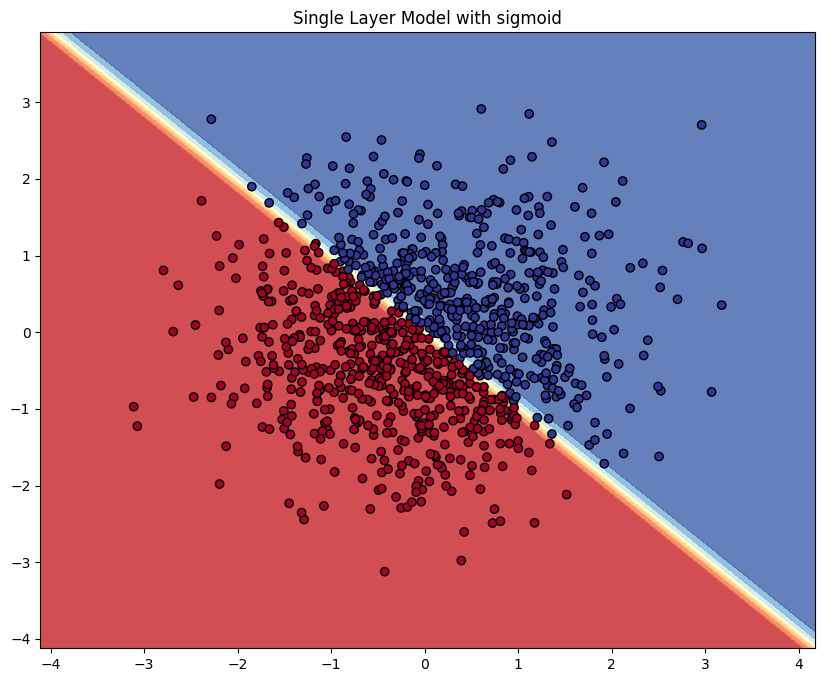

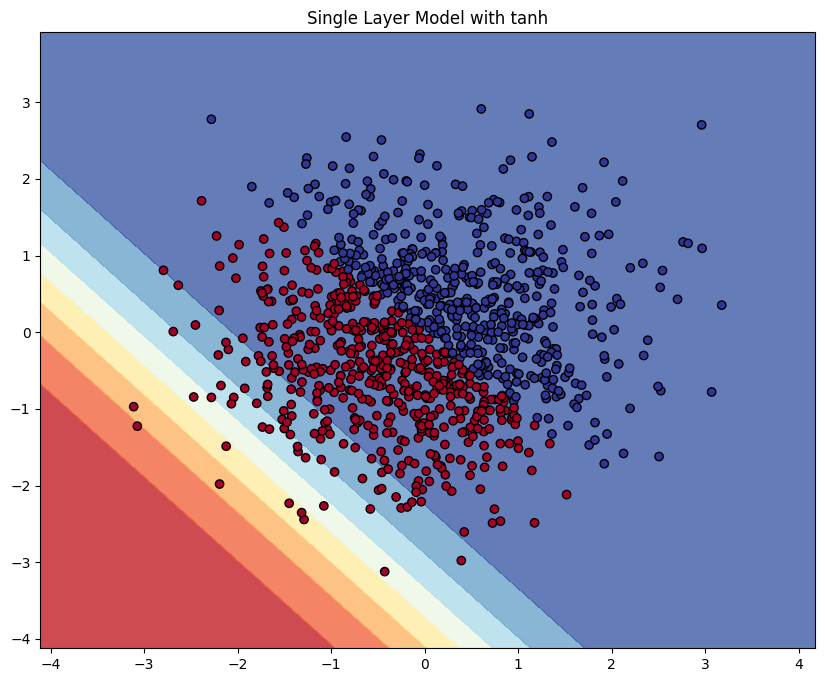

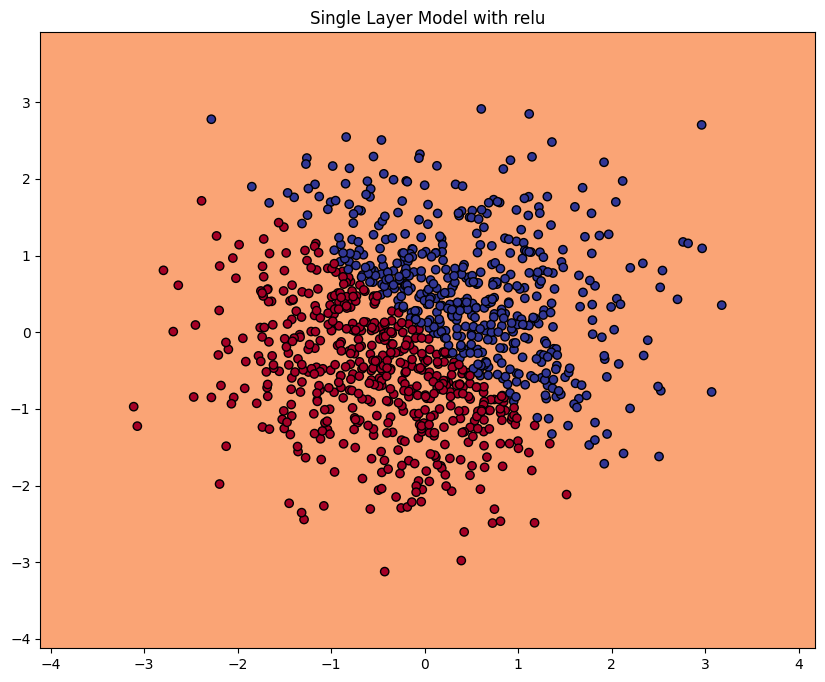

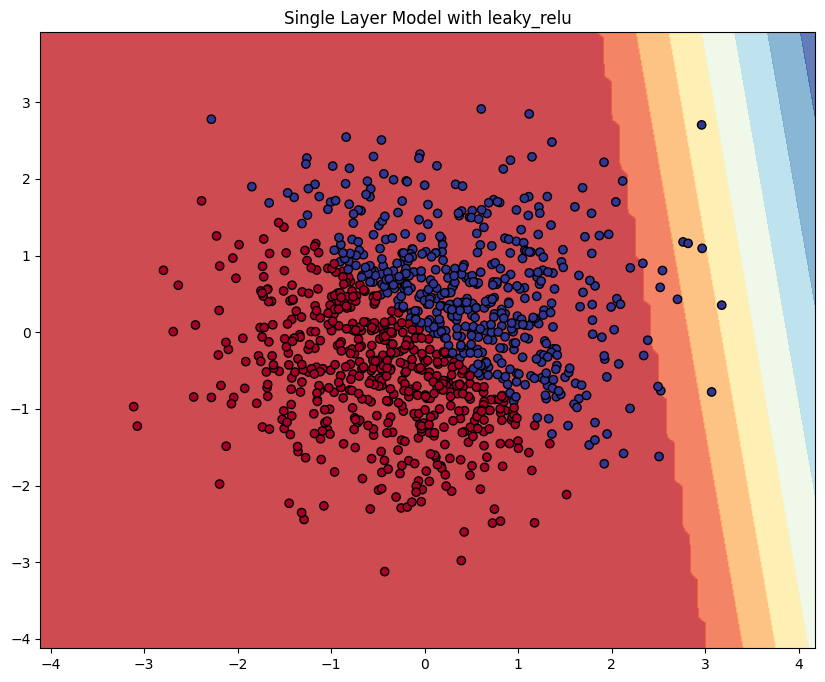

In [8]:
def generate_data(n_samples=1000):
    X = np.random.randn(n_samples, 2)
    y = (X[:, 0] + X[:, 1] > 0).astype(int).reshape(-1, 1)
    return X, y

def train_and_plot(model, X, y, title):
    model.train(X, y)
    
    # Create a meshgrid
    xx, yy = np.meshgrid(np.linspace(X[:, 0].min()-1, X[:, 0].max()+1, 100),
                         np.linspace(X[:, 1].min()-1, X[:, 1].max()+1, 100))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(10, 8))
    plt.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdYlBu)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), cmap=plt.cm.RdYlBu, edgecolor='black')
    plt.title(title)
    plt.show()

# Generate data
X, y = generate_data()

# Train and plot single-layer models
activations = ['sigmoid', 'tanh', 'relu', 'leaky_relu']
for activation in activations:
    model = SingleLayerModel(2, 1,activation)
    train_and_plot(model, X, y, f"Single Layer Model with {activation}")

